# Capacitación AUC ROC

    Configuración del Cluster (todo el código es en python)

In [1]:
%%configure -f
{"driverMemory": "10G", "driverCores": 4,"executorMemory":"10G","executorCores":4}

In [2]:
%%html


<style>
div.output_area pre{
word-wrap: unset !important;
white-space: pre !important;
}

@media (min-width: 1100px) {
.container {
width: 100%;
}}

@media (max-width: 1020px) {
.container {
width: 100%;
}}

@media (min-width: 767) {
.container {
width: 100%;
}}
</style>

### Librerías

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1649344677852_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Librerías para cálculo de AUC ROC

In [4]:
from sklearn import metrics

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Función a mano para cálculo de AUC ROC (utilizando sólo los puntos de corte de deciles)

In [5]:
def bkt_odds(Folio,Score,Flag,bins=10,negative_relationship=True):
    '''
    Función que genera tabla de Odds y tabla de resumen de resultados, para 
    cualquier BKT que tenga como input un único score, y un flag de malo.
            Parameters
            ----------
                    Folio : array_like
                        Input array que contiene el folio de las personas a las que se les realiza el BKT.
                    Score : array_like
                        Input array que contiene el score asignado a cada observación. Representa la tendencia de que el evento suceda.
                        Debe tener el mismo length que el array de Folio. 
                    Flag : array_like 
                        Input que indica para cada observación si el evento sucede o no. TOma el valor de 1 si el evento sucede, y 0 
                        en otros casos. 
                    bins : int, default `10`
                        Integer that indicates the number of equally-sized bins to split the data into.
                    negative_relationship : bool, default `True`
                        Determine the relationship between the score and the target.
                        If `negative_relationship == True`, then a LOW score means HIGH probability of default.
                        If `negative_relationship == False`, then a LOW score means LOW probability of default.
                    
                    
            Returns
            ----------
                    two pandas.DataFrameS object:
                        - Tabla ODDS: Muestra los indicadores de mora asociados a los bines creados. 
                        - Resumen_resultados: Resumen de los resultados encontrados (población, # malos, 
                                                                                     mora asociada, mora acum,
                                                                                     KS, y ROC)
            Notes
            ----------
                    
    '''
    
    import numpy as np
    import pandas as pda
    
    bb = pd.DataFrame({'Id':Folio,'Score':Score,'Mora':Flag})
    bb['bin'] = pd.qcut(bb['Score'],bins,duplicates='drop')
    
    Odds=bb.groupby('bin').agg({'Mora':['size','sum','mean']}).reset_index()
    Odds.columns=['Bin','Personas','Malos','Bad_rate']
    Odds['Buenos'] = Odds['Personas'] - Odds['Malos']    
    
    if negative_relationship == False:
        Odds = Odds.sort_index(ascending=False)
        
    Odds['Good_rate']=Odds['Buenos'].div(Odds['Buenos'].sum())
    Odds['Tasa_malos_acum'] = Odds['Malos'].cumsum().div(Odds['Malos'].sum())
    Odds['Tasa_buenos_acum'] = Odds['Buenos'].cumsum().div(Odds['Buenos'].sum())
    
    Odds['M_1']=Odds['Malos'].values[::-1].cumsum()
    Odds['M_2']=Odds['M_1'].values[::-1]
    
    Odds['P_1']=Odds['Personas'].values[::-1].cumsum()
    Odds['P_2']=Odds['P_1'].values[::-1]
    
    Odds['Mora_acumulada']=Odds['M_2'].div(Odds['P_2'])
    
    Odds['KS'] = np.abs(Odds['Tasa_malos_acum'] - Odds['Tasa_buenos_acum'])
    Odds['Var_ROC']=Odds['Good_rate']*Odds['Tasa_malos_acum']
    
    Ks_CI=round(Odds['KS'].max(),4)*100
    
    ROC=Odds['Var_ROC'].sum()*100
    
    tabla_ODDS=Odds[['Bin','Personas','Buenos','Malos','Bad_rate','Mora_acumulada','KS']]
    
    resultados={'Casos':bb.shape[0],
                'Malos':bb['Mora'].sum(),
                'Tasa de Mora':bb['Mora'].sum()/bb['Mora'].count(),
                'KS':Ks_CI,
                'ROC':ROC
                }
    
    resultados=pd.DataFrame(resultados,columns=['Casos','Malos','Tasa de Mora','KS','ROC'],index=['Resumen_resultados'])
    return(tabla_ODDS,resultados)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Data Ejemplo

In [14]:
df = pd.read_csv("ruta", sep='|',
                 dtype={
                     'cuenta_fix': str
                 })
print(df['LLAVE'].nunique())
df = df[['folio','bandera','.fitted']]
df.columns = ['folio','bandera','score']
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

284017
       folio  bandera     score
0  100016029        0  0.062860
1  100084693        0  0.362405
2  100087273        0  0.328058
3   10008893        0  0.073263
4  100094724        1  0.263119

        #### Array Observaciones Reales

In [7]:
y = df[['bandera']]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       #### Array de Score

In [8]:
score = df[['score']]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Cálculo Directo

In [9]:
metrics.roc_auc_score(y, score)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.6275465959347094

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

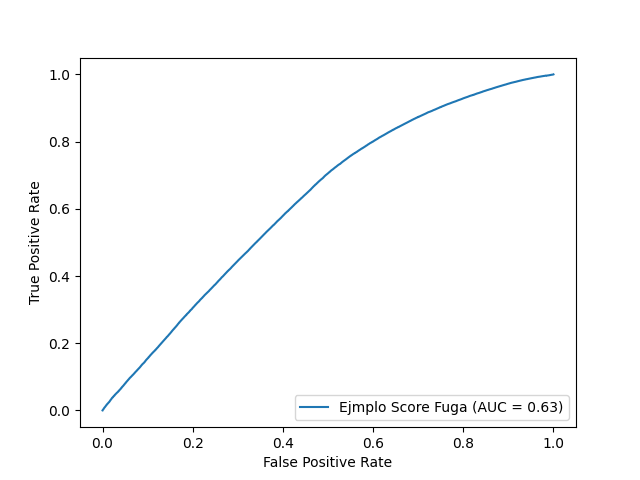

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(y, score)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Ejmplo Score Fuga')
display.plot()

plt.show()
%matplot plt 

## Cálculo con función propia

In [11]:
tabla_odds,resumen = bkt_odds(df['folio'],df['score'],df['bandera'],bins=10,negative_relationship=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
resumen

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                     Casos   Malos  Tasa de Mora     KS        ROC
Resumen_resultados  284184  121374      0.427097  20.69  67.326541

**Comentario:** 
        
        Difiere el valor final de AUC ROC por los puntos de corte considerados, diferencias no significativas